# Setup Environment and LLM

In [ ]:
import os
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Auto-ConfigFee"
os.environ["TAVILY_API_KEY"] = "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"

In [9]:
import os
from langchain_google_vertexai.model_garden import ChatAnthropicVertex
project = "gen-lang-client-0882885035"
location = "europe-west1"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/leduy/PycharmProjects/Funny_days_wRAG/credentials/gen-lang-client-0882885035-7a0a41538ab7.json"
# Initialise the Model
claude35_sonnet = ChatAnthropicVertex(
    model_name="claude-3-5-sonnet@20240620",
    project=project,
    location=location,
    max_output_tokens=4096,
)

In [10]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

# Create Agent function with Prefix of system message

In [11]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_config_fee_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                """You are an intelligent Fee config agent responsible for extracting information from images and mapping it to a predefined schema. Always follow the schema exactly as outlined, ensuring no fields are missed except under the limited conditions specified below. Here’s a guide:
                # 1. Ask for Information: Before generating any schema, ensure you request all required information from the user within bracket.
                # 2. Schema Mapping: Map the extracted values to the schema as described:
                - Follow the format for schemeCode and schemeName carefully.
                - Use 'in' for multiple values separated by commas without spaces (e.g., 'field in value1,value2,value3') and '=' for a single value (e.g., 'field = value'). And use '>', '<', '>=', '<=' for fee conditions (e.g., 'fee > value'). 
                # 3. Value Handling:
                - Convert percentages (e.g., 1.5% or 0.3%) to decimal form (e.g., 0.015 or 0.003) for fee-related values.
                - Use the provided examples and context to determine appropriate values for fields.
                # 4. Generate Schema: Generate the schema in the following Excel table format: 
                {system_message}
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [12]:
def create_alpha_agent(llm, tools):
    """Create an agent apha."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                """
               **Objective:** Classify transaction types into INTERNATIONAL_CARD_CONFIG, INTERNATIONAL_CARD_CONFIG_ACC_COND, LOCAL_CARD_CONFIG, LOCAL_CARD_CONFIG_ACC_COND, QR_CONFIG, and QR_CONFIG_ACC_COND categories based on provided fee tables, including conditions for accumulate calculations where applicable.

                    **Instructions:**
                    
                    1. **Clarify Ambiguities**: Ensure no part of the instruction is unclear.
                    
                    2. **Categorization Rules**:
                       - **QR_CONFIG**: QR code transactions from banking apps, e-wallets, and credit card sources.
                       - **QR_CONFIG_ACC_COND**: QR code transactions with conditions related to the number of transactions or total transaction amount.
                       - **LOCAL_CARD_CONFIG**: Domestic ATM card transactions (ATM, NAPAS).
                       - **LOCAL_CARD_CONFIG_ACC_COND**: Domestic ATM card transactions with conditions related to the number of transactions or total transaction amount.
                       - **INTERNATIONAL_CARD_CONFIG**: International card transactions issued both within and outside the country.
                       - **INTERNATIONAL_CARD_CONFIG_ACC_COND**: International card transactions with conditions related to the number of transactions or total transaction amount.
                    
                    3. **Steps**:
                       - Identify and list QR transactions under QR_CONFIG or QR_CONFIG_ACC_COND based on conditions.
                       - Identify and list local card transactions under LOCAL_CARD_CONFIG or LOCAL_CARD_CONFIG_ACC_COND based on conditions.
                       - Identify and list international card transactions under INTERNATIONAL_CARD_CONFIG or INTERNATIONAL_CARD_CONFIG_ACC_COND based on conditions.
                    
                    4. **Few-Shot Examples**:
                       - Input: "Thanh toán mã QR (từ hơn 41 ứng dụng ngân hàng, 5 ví điện tử và nguồn tiền từ thẻ tín dụng)"
                         Output: QR_CONFIG
                       - Input: "Thẻ nội địa (ATM, NAPAS)"
                         Output: LOCAL_CARD_CONFIG
                       - Input: "Thẻ Quốc tế Visa, JCB, MasterCard phát hành trong lãnh thổ Việt Nam"
                         Output: INTERNATIONAL_CARD_CONFIG
                       - Input: "Thẻ Quốc tế Visa, JCB, MasterCard phát hành ngoài lãnh thổ Việt Nam"
                         Output: INTERNATIONAL_CARD_CONFIG
                       - Input: "Thẻ Quốc tế Amex phát hành trong lãnh thổ Việt Nam"
                         Output: INTERNATIONAL_CARD_CONFIG
                       - Input: "Thẻ Quốc tế Amex phát hành ngoài lãnh thổ Việt Nam"
                         Output: INTERNATIONAL_CARD_CONFIG
                       - Input: "Mã QR (thanh toán bằng ứng dụng của Ngân Hàng)"
                         - If monthly transactions < 10,000: 
                           - Output: QR_CONFIG_ACC_COND, 1600 VND/transaction
                         - If monthly transactions >= 10,000:
                           - Output: QR_CONFIG_ACC_COND, 1100 VND/transaction
                       - Input: "Mã QR (thanh toán bằng ví điện tử SmartPay)"
                         Output: QR_CONFIG, 0.65% fee (capped at 22,000 VND/transaction)
                       - Input: "Thẻ nội địa (ATM, NAPAS)"
                         - If monthly transactions > 500:
                           - Output: LOCAL_CARD_CONFIG_ACC_COND, 0.85% fee
                       - Input: "Thẻ Quốc tế Visa, JCB, MasterCard phát hành trong lãnh thổ Việt Nam"
                         - If monthly transactions > 10,000:
                           - Output: INTERNATIONAL_CARD_CONFIG_ACC_COND, 1.5% fee
                    
                    5. **Error Handling**:
                       - Correct any identified categorization errors and ensure all entries are in the correct categories without needing user confirmation.

                Format the model output as a Python list. Example:
                ```python
                [
                    "QR_CONFIG",
                    "LOCAL_CARD_CONFIG",
                    "INTERNATIONAL_CARD_CONFIG_ACC_COND"
                ]
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [13]:
agent_alpha = create_alpha_agent(claude35_sonnet,
                                                [],
                                            )

In [26]:
import base64
import httpx

image_url = "https://static.paysmart.com.vn/store/202405/0931515069_30663166690912810.png"
image_url2 = "https://static.paysmart.com.vn/store/202405/0931515069_30663166691125877.png"
image_url3 = "https://static.paysmart.com.vn/store/202405/0931515069_30663166691258981.png"
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
image_data2 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
image_data3 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

In [27]:
message = HumanMessage(
    content=[
        {"type": "text", "text": """Nhiệm vụ của bạn là phân biệt có chai và lon bia trong hình này không? và nếu có bia thì là gì bia gì?
Trong list bia [333,
lac_viet,
saigon_export_premium,
saigon_gold,
saigon_larger,
saigon_special,
]
nếu chỉ có một loại bia thì trả về [tên bia trong list]
nếu có nhiều loại bia trong hình thì trả về 1 list bia [list bia trong hình]
Nếu chai và lon bia không thuộc thương hiệu nào ở trên, đánh nhãn [others]
Lưu ý là chai và lon bia.
"""},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data2}"},
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data3}"},
        }
    ],
)
response = claude35_sonnet.invoke([message])
print(response.content)

Dựa trên thông tin và hình ảnh được cung cấp, tôi sẽ thực hiện đánh giá theo các bước như sau:

## Bước 1: Đánh giá sơ bộ

1. Đánh giá khu vực kinh tế: 75/100
- Dựa vào tên đường "Nguyễn Chí Thanh" và việc có một khách sạn lớn ở đây, có thể đoán đây là khu vực khá sầm uất. Nguyễn Chí Thanh thường là đường lớn ở các thành phố.

2. Đánh giá khả năng chấp nhận thanh toán không tiền mặt: 80/100
- Là một khách sạn lớn, khả năng cao sẽ chấp nhận thanh toán không tiền mặt.

3. Đánh giá rủi ro gian lận: 90/100
(Giải thích: Rủi ro gian lận càng thấp thì điểm số càng cao)
- Khách sạn lớn thường có hệ thống quản lý chặt chẽ, rủi ro gian lận thấp.

4. Phân tích thông tin cửa hàng: 85/100
- Phong cách thiết kế: Sang trọng
- Diện tích bảng hiệu: Từ 3 mét trở lên
- Không gian bên trong: Rộng rãi (dự đoán)
- Diện tích bên trong: Khoảng 500-1000m2 (ước tính)
- Giới tính và tuổi người được chụp: Không có người trong hình
- Mã QR/máy POS: Không thấy trong hình
- Sản phẩm/dịch vụ: Dịch vụ khách sạn, lưu t

In [23]:
import base64
# Specify the image path
image_path_fee = "https://static.paysmart.com.vn/store/202405/0905661364_31099474012526788.png"

# Read the image file and convert to Base64
with open(image_path_fee, "rb") as image_file:
    base64_string_fee = base64.b64encode(image_file.read()).decode('utf-8')
# Output the Base64 string
# print(base64_string_fee)

# Create a HumanMessage with the image
message = HumanMessage(
    content=[
        {"type": "text", "text": "return me table in image"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_data}"},
        },
    ],
)
table_response = claude35_sonnet.invoke([message])
print(table_response.content)

FileNotFoundError: [Errno 2] No such file or directory: 'https://static.paysmart.com.vn/store/202405/0905661364_31099474012526788.png'

In [18]:
config_type_choosed = agent_alpha.invoke(
    {
        "messages": [
            HumanMessage(
                content=f'{table_response.content}'
            )
        ],
    },
)

NameError: name 'table_response' is not defined

In [9]:
config_type_choosed.content

'Based on the provided table and instructions, here\'s the categorization of the transaction types:\n\n```python\n[\n    "INTERNATIONAL_CARD_CONFIG",\n    "LOCAL_CARD_CONFIG",\n    "QR_CONFIG_ACC_COND",\n    "QR_CONFIG"\n]\n```\n\nExplanation:\n\n1. "Thẻ Quốc Tế (phát hành tại Việt Nam và ngoài lãnh thổ Việt Nam)" is categorized as INTERNATIONAL_CARD_CONFIG. Although it has a fee structure, there are no conditions related to the number of transactions or total transaction amount that would qualify it for the ACC_COND category.\n\n2. "Thẻ Nội Địa" is categorized as LOCAL_CARD_CONFIG. Similar to the international card, it has a fee structure but no accumulation conditions.\n\n3. "Mã QR (thanh toán bằng ứng dụng của Ngân Hàng)" is categorized as QR_CONFIG_ACC_COND because it has different fees based on the number of monthly transactions (below 10,000 and from 10,000 onwards).\n\n4. "Mã QR (thanh toán bằng ví điện tử SmartPay)" is categorized as QR_CONFIG. Although it has a percentage fee 

# QR Code Config Fee

In [10]:
qr_system_message = """
                   Here is template for QR code only, so let mapping fee from QR code to the schema. The no number of schema(no_of_schema) will be information from the table below.
                   ```fee_config\n
                    schemeCode	schemeName	layer	attribute	operator	value
                    "MID_{merchant_id}_00005_{no_of_schema}_{no_of_sub_schema}
                    
                    MID_{merchant_id}: Use the merchant ID provided.
                    00005: Fixed value.
                    {no_of_schema}: The number of the schema, formatted as 01, 02, etc.
                    {no_of_sub_schema}: The sub-number of the schema, formatted as 01, 02, etc.
                    For example:
                    
                    The first schema would be MID_{merchant_id}_00005_01_01
                    The second sub-schema under the first schema would be MID_{merchant_id}_00005_01_02
                    The first sub-schema under the second schema would be MID_{merchant_id}_00005_02_01	Thanh toán mã QR	condition_trans_selector	buyer_sf_acct_type	in	APP,WALLET,OTHERS
                            condition_trans_selector	og_trans_type	=	Purchase
                            condition_trans_selector	og_service_type	in	QR_CODE,STATIC_QR,PAYMENT_GATEWAY
                            condition_trans_selector	og_platform	in	PAYMENT_GATEWAY,OTHERS
                            condition_trans_selector	og_status	=	1
                            condition_entity_selector	merc_id	=	{merchant_id}
                            fee_setup	x1	=	om_order_amount
                            fee_setup	pct_fee	=	{int number}  # 0 if not mention
                            fee_setup	fix_fee	=	{int number} # 0 if not mention
                            fee_setup	max_fee	=	{int number} # 0 if not mention
                            fee_setup	min_fee	=	{int number} # 0 if not mention
                            effective_date	start_date	=	Ask  user to fill this Fields and format follow e.g: 01/01/2024
                            effective_date	end_date	=	Ask  user to fill this Fields and format follow e.g: 12/31/2024
                            additional_condition	function	=	MDR-FeePerTrans
                            pay_fee_ratio	pay_merchant_amount	=	1
                            recv_fee_ratio	recv_sp_amount	=	1 
                    Return Json format for me.
                    """

In [11]:
qr_config_agent = create_config_fee_agent(claude35_sonnet,
                                                [],
                        system_message=qr_system_message,
                                            )

In [12]:
result = qr_config_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content=f"""{table_response.content}\n merchant id = 12838123 , start_date: 12/02/2024, end_date: 12/02/2025"""
            )
        ],

    },
)


In [13]:
result.content

'Thank you for providing the information. Based on the table and details you\'ve shared, I\'ll now generate the fee configuration schema for the QR code payment methods (rows 3 and 4 in the table). I\'ll create separate schemas for each QR payment type and transaction volume threshold.\n\n```json\n{\n  "fee_config": [\n    {\n      "schemeCode": "MID_12838123_00005_01_01",\n      "schemeName": "Thanh toán mã QR",\n      "layer": [\n        {\n          "condition_trans_selector": [\n            {"buyer_sf_acct_type": "in", "value": "APP,WALLET,OTHERS"},\n            {"og_trans_type": "=", "value": "Purchase"},\n            {"og_service_type": "in", "value": "QR_CODE,STATIC_QR,PAYMENT_GATEWAY"},\n            {"og_platform": "in", "value": "PAYMENT_GATEWAY,OTHERS"},\n            {"og_status": "=", "value": "1"}\n          ],\n          "condition_entity_selector": [\n            {"merc_id": "=", "value": "12838123"}\n          ],\n          "fee_setup": [\n            {"x1": "=", "value"

# Config MDR International Card

In [47]:
international_card_system_prompt = """
Here is template for International Card schema config only, so let mapping International Card fee relate to the schema fee config follow format. The no number of schema(no_of_schema) will be information from the table below.
```fee_config\n
schemeName	layer	attribute	operator	value
Thẻ quốc tế VISA, MASTER, JCB phát hành trong VN	condition_trans_selector	buyer_sf_acct_subtype	=	INTERNATIONAL_CARD
	condition_trans_selector	og_trans_type	{in or =}	base on context user provide, default is 'Purchase' if not mention,value available{Purchase, Refund}
	condition_trans_selector	buyer_sf_issuer_country	=	Base on schema context {INSIDE_VN, OUTSIDE_VN}
	condition_trans_selector	buyer_sf_acct_type	=	CARD
	condition_trans_selector	buyer_sf_acct_issuer	in	Base on context, value available:{VISA,MASTER,JCB,AMEX,...}
	condition_entity_selector	merc_id	=	
	condition_trans_selector	og_status	=	1
	condition_trans_selector	og_platform	{in or =}	Ask user, value available {PAYMENT_GATEWAY,SMARTPOS,OTHERS}
	fee_setup	x1	=	om_order_amount
	fee_setup	pct_fee	=	{int number} # 0 if not mention
	fee_setup	fix_fee	{int number} # 0 if not mention
	fee_setup	max_fee	=	{int number} # 0 if not mention
	fee_setup	min_fee	=	{int number} # 0 if not mention
	effective_date	start_date	=	Ask  user to fill this Fields and format follow e.g: 01/01/2024
	effective_date	end_date	=	Ask  user to fill this Fields and format follow e.g: 12/31/2024
	additional_condition	function	=	MDR-FeePerTrans
	pay_fee_ratio	pay_merchant_amount	=	1
	recv_fee_ratio	recv_sp_amount	=	1
"""

In [48]:
international_card_config_agent = create_config_fee_agent(claude35_sonnet,
                                                [],
                        system_message=international_card_system_prompt,
                                            )

In [49]:
result_international_card = international_card_config_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content=f"""{table_response.content}\n merchant id = 12838123 , start_date: 12/02/2024, end_date: 12/02/2025, and Can you return for me JSON format with and prefix with syntax highlighting tags in your instruction"""
            )
        ],
    },
)


In [50]:
result_international_card.content

'Certainly! I\'ll generate the fee config schema for the International Card transactions based on the information provided. I\'ll create two separate schemas for cards issued inside and outside Vietnam. Here\'s the JSON format with syntax highlighting tags:\n\n```json\n{\n  "no_of_schema": 2,\n  "fee_config": [\n    {\n      "schemeName": "Thẻ quốc tế VISA, MASTER, JCB phát hành trong VN",\n      "layer": [\n        {\n          "condition_trans_selector": [\n            {"buyer_sf_acct_subtype": "INTERNATIONAL_CARD"},\n            {"og_trans_type": "Purchase"},\n            {"buyer_sf_issuer_country": "INSIDE_VN"},\n            {"buyer_sf_acct_type": "CARD"},\n            {"buyer_sf_acct_issuer in": "VISA,MASTER,JCB"},\n            {"og_status": "1"},\n            {"og_platform": "PAYMENT_GATEWAY,SMARTPOS,OTHERS"}\n          ],\n          "condition_entity_selector": [\n            {"merc_id": "12838123"}\n          ],\n          "fee_setup": [\n            {"x1": "om_order_amount"},\

### International Card Config Fee 2 for refund transaction by order example

In [65]:
result_international_card2 = international_card_config_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""STT	Hình Thức Thanh Toán	Phí Dịch Vụ (% của Tổng Giá Trị Giao Dịch Thành công)\
1	Thẻ Quốc Tế (phát hành tại Việt Nam)	1.8%\
2	Thẻ Quốc Tế (phát hành ngoài Việt Nam)	2.5%\
3	Thẻ Nội Địa	0.88%\
4	Mã QR	0.44%\n merchant id = 12838123 , start_date: 12/02/2024, end_date: 12/02/2025, chỉ tính phí cho giao dịch refund"""
            )
        ],
    },
)


In [66]:
result_international_card2

AIMessage(content='Certainly! I\'ll generate the schema based on the information provided. Before I do that, I need to clarify a few details:\n\n[Can you confirm if the International Card transactions should include both Purchase and Refund types, or just Refund as mentioned? Also, which platforms should be included for these transactions (PAYMENT_GATEWAY, SMARTPOS, OTHERS)?]\n\nNow, I\'ll proceed with generating the schema based on the information provided and assuming we\'re including both types of International Cards (issued inside and outside Vietnam). I\'ll create two separate schemas for each case:\n\nSchema 1: International Card issued in Vietnam\n\nschemeName\tlayer\tattribute\toperator\tvalue\nThẻ quốc tế VISA, MASTER, JCB phát hành trong VN\tcondition_trans_selector\tbuyer_sf_acct_subtype\t=\tINTERNATIONAL_CARD\n\tcondition_trans_selector\tog_trans_type\t=\tRefund\n\tcondition_trans_selector\tbuyer_sf_issuer_country\t=\tINSIDE_VN\n\tcondition_trans_selector\tbuyer_sf_acct_typ

# MDR Fee Local Card

In [52]:
local_card_system_prompt = """
Here is template for Local Card schema config only, so let mapping Local Card fee relate to the schema fee config follow format. The no number of schema(no_of_schema) will be information from the table below.
```fee_config
schemeCode	schemeName	layer	attribute	operator	value
"MID_{merchant_id}_00005_{no_of_schema}_{no_of_sub_schema}

MID_{merchant_id}: Use the merchant ID provided.
00005: Fixed value.
{no_of_schema}: The number of the schema, formatted as 01, 02, etc.
{no_of_sub_schema}: The sub-number of the schema, formatted as 01, 02, etc.
For example:

The first schema would be MID_{merchant_id}_00005_01_01
The second sub-schema under the first schema would be MID_{merchant_id}_00005_01_02
The first sub-schema under the second schema would be MID_{merchant_id}_00005_02_01	
Thẻ nội địa	condition_trans_selector	buyer_sf_acct_issuer	=	NAPAS
	condition_trans_selector	og_trans_type	=	ask to fill, value available: {Purchase, Refund}
	condition_trans_selector	buyer_sf_acct_type	=	CARD
	condition_trans_selector	buyer_sf_acct_subtype	=	ATM_CARD
	condition_entity_selector	merc_id	=	{merchant_id}
	condition_trans_selector	og_status	=	1
	condition_trans_selector	og_platform	=	PAYMENT_GATEWAY
	fee_setup	x1	=	om_order_amount
	fee_setup	pct_fee	=	{int number} # 0 if not mention
	fee_setup	fix_fee	=	{int number} # 0 if not mention
	fee_setup	max_fee	=	{int number}    # 0 if not mention
	fee_setup	min_fee	=	{int number}    # 0 if not mention
	effective_date	start_date	=	Ask  user to fill this Fields and format follow e.g: 01/01/2024
	effective_date	end_date	=	Ask  user to fill this Fields and format follow e.g: 12/31/2024
	additional_condition	function	=	MDR-FeePerTrans
	pay_fee_ratio	pay_merchant_amount	=	1
	recv_fee_ratio	recv_sp_amount	=	1
"""

In [53]:
local_card_config_agent = create_config_fee_agent(claude35_sonnet,
                                                [],
                        system_message=local_card_system_prompt,
                                            )

In [54]:
local_card_config_agent = local_card_config_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content=f"""f{table_response.content}\n merchant id = 12838123 , start_date: 12/02/2024, end_date: 12/02/2025, chỉ tính phí cho giao dịch refund, mọi thông tin tôi cung cấp tôi đã kiểm tra"""
            )
        ],
    },
)

In [55]:
local_card_config_agent.content

"Thank you for providing the information. I'll now generate the fee config schema for the Local Card (Thẻ Nội Địa) based on the details you've given. \n\n```fee_config\nschemeCode\tschemeName\tlayer\tattribute\toperator\tvalue\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tbuyer_sf_acct_issuer\t=\tNAPAS\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tog_trans_type\t=\tRefund\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tbuyer_sf_acct_type\t=\tCARD\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tbuyer_sf_acct_subtype\t=\tATM_CARD\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_entity_selector\tmerc_id\t=\t12838123\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tog_status\t=\t1\nMID_12838123_00005_01_01\tThẻ nội địa\tcondition_trans_selector\tog_platform\t=\tPAYMENT_GATEWAY\nMID_12838123_00005_01_01\tThẻ nội địa\tfee_setup\tx1\t=\tom_order_amount\nMID_12838123_00005_01_01\tThẻ nội địa\tfee_setu

# QR Have Accumulate Condition

In [132]:
qr_system_prompt_have_condition_accumulate = """
    This Schema is for QR code have condition accumulate only(just use this schema for QR but have condition about number transaction or Amount of transactions, so let mapping fee from QR code to the schema. The no number of schema(no_of_schema) will be information from the table below.
    \n
    ```fee_config
    schemeCode	schemeName	layer	attribute	operator	value
	Thanh toán mã QR có số lượng giao dịch trong 1 tháng >= k	condition_trans_selector	buyer_sf_acct_type	in	APP,WALLET,OTHERS
		condition_trans_selector	og_trans_type	=	Purchase
		condition_trans_selector	og_service_type	in	QR_CODE,STATIC_QR,POS
		condition_trans_selector	og_platform	in	SMARTPOS,OTHERS
		condition_trans_selector	og_status	=	1
		condition_entity_selector	merc_id	=	
		preEval_trans_selector	buyer_sf_acct_type	in	APP,WALLET,OTHERS
		preEval_trans_selector	og_trans_type	=	Purchase
		preEval_trans_selector	og_service_type	in	QR_CODE,STATIC_QR,POS
		preEval_trans_selector	og_platform	in	SMARTPOS,OTHERS
		preEval_trans_selector	og_status	=	1
		preEval_entity_selector	merc_id	=	
		preEval_timestamp_selector	time_unit	=	1_month
		fee_setup	x1	=	om_order_amount
		fee_setup	pct_fee	=	0,00
		fee_setup	fix_fee	=	0
		fee_setup	max_fee	=	0
		fee_setup	min_fee	=	0
		effective_date	start_date	=	01/01/2024
		effective_date	end_date	=	12/31/2024
		additional_condition	function	=	Acc-FeePerTrans
		additional_condition	acc_scope	=	merc_id
		additional_condition	acc_field	=	om_order_amount
		
		# if condition accumulate active is Amount, add this field, if not, remove this field
        acc_condition	AccAmount	one of this operator: {=,<,>,<=,>=}	k  
        
        # if condition accumulate active is Amount, add this field, if not, remove this field
        acc_condition	NumTrans	one of this operator: {=,<,>,<=,>=}	k

		pay_fee_ratio	pay_merchant_amount	=	1
		recv_fee_ratio	recv_sp_amount	=	1
"""

In [137]:
table_fee_have_acc_follow_number_transaction = """
| STT | Hình Thức/Nguồn Thanh Toán                                      | Số lượng Giao Dịch Hàng Tháng  | Phí Xử Lý Giao Dịch (Đồng/Giao Dịch Thành Công) | Phí Dịch Vụ (% của Tổng Giá Trị Giao Dịch Hàng Tháng)                |
|-----|------------------------------------------------------------------|--------------------------------|--------------------------------------------------|---------------------------------------------------------------------|
| 1   | Thẻ Quốc Tế (phát hành tại Việt Nam và ngoài lãnh thổ Việt Nam) |                                | 2200                                             | 1.50%                                                               |
| 2   | Thẻ Nội Địa                                                       |                                | 500                                              | 0.85%                                                               |
| 3   | Mã QR (thanh toán bằng ứng dụng của Ngân Hàng)                    | Dưới 10.000                     | 1600                                             |                                                                     |
|     |                                                                  | Từ 10.000                      | 1100                                             |                                                                     |
| 4   | Mã QR (thanh toán bằng ví điện tử SmartPay)                       |                                |                                                  | 0.65% (không vượt quá 22.000VNĐ/giao dịch thành công)              |

"""

In [159]:
table_fee_have_acc_follow_amount_transaction = """
| STT | Hình Thức/Nguồn Thanh Toán                                      | Số lượng Giao Dịch Hàng Tháng  | Tổng số tiền giao dịch trong tháng (Đồng/Giao Dịch Thành Công) | Phí Dịch Vụ (% của Tổng Giá Trị Giao Dịch Hàng Tháng)                |
|-----|------------------------------------------------------------------|--------------------------------|------------------------------------------------------------------|---------------------------------------------------------------------|
| 1   | Thẻ Quốc Tế (phát hành tại Việt Nam và ngoài lãnh thổ Việt Nam) |                                | 2200                                                             | 1.50%                                                               |
| 2   | Thẻ Nội Địa                                                       |                                | 500                                                              | 0.85%                                                               |
| 3   | Mã QR (thanh toán bằng ứng dụng của Ngân Hàng)                    | Dưới 300 000 000                | 1600                                                             |                                                                     |
|     |                                                                  | Từ 300 000 000 trở lên          | 1100                                                             |                                                                     |
| 4   | Mã QR (thanh toán bằng ví điện tử SmartPay)                       |                                |                                                                  | 0.65% (không vượt quá 22.000VNĐ/giao dịch thành công)              |

"""

In [160]:
qr_accumulate_config_agent = create_config_fee_agent(claude35_sonnet,
                                                [],
                        system_message=qr_system_prompt_have_condition_accumulate,
                                            )

In [161]:
qr_accumulate_config_agent = qr_accumulate_config_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content=f"""{table_fee_have_acc_follow_amount_transaction}\
\n merchant id = 12838123 , start_date: 12/02/2024, end_date: 12/02/2025, chỉ tính phí cho giao dịch refund, mọi thông tin tôi cung cấp tôi đã kiểm tra, not ask me again, just gen, return me json, please attention to where is fix fee, where is percent fee"""
            )
        ],
    },
)


In [162]:
qr_accumulate_config_agent

AIMessage(content='Based on the information provided, I\'ll generate the schema for QR code payments with accumulation conditions as requested. Here\'s the JSON representation:\n\n```json\n[\n  {\n    "schemeCode": "QR_ACC_AMT_1",\n    "schemeName": "Thanh toán mã QR có số lượng giao dịch trong 1 tháng < 300000000",\n    "condition_trans_selector": {\n      "buyer_sf_acct_type": "in APP,WALLET,OTHERS",\n      "og_trans_type": "= Purchase",\n      "og_service_type": "in QR_CODE,STATIC_QR,POS",\n      "og_platform": "in SMARTPOS,OTHERS",\n      "og_status": "= 1"\n    },\n    "condition_entity_selector": {\n      "merc_id": "= 12838123"\n    },\n    "preEval_trans_selector": {\n      "buyer_sf_acct_type": "in APP,WALLET,OTHERS",\n      "og_trans_type": "= Purchase",\n      "og_service_type": "in QR_CODE,STATIC_QR,POS",\n      "og_platform": "in SMARTPOS,OTHERS",\n      "og_status": "= 1"\n    },\n    "preEval_entity_selector": {\n      "merc_id": "= 12838123"\n    },\n    "preEval_timest

In [164]:
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [170]:
alpha_system_message = """holdon"""

In [171]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = claude35_sonnet

# Agent Alpha agent and node
alpha_agent = create_alpha_agent(llm, [], system_message=alpha_system_message)
alpha_node = functools.partial(agent_node, agent=alpha_agent, name="Alpha")

# international card agent and node
international_card_agent = international_card_config_agent
research_node = functools.partial(agent_node, agent=international_card_agent, name="International Card")

# qr agent and node
qr_agent = qr_config_agent
chart_node = functools.partial(agent_node, agent=qr_agent, name="QR")

# local card agent and node
local_card_agent = local_card_config_agent
local_card_node = functools.partial(agent_node, agent=local_card_agent, name="Local Card")

# qr accumulate agent and node
qr_accumulate_agent = qr_accumulate_config_agent
qr_accumulate_node = functools.partial(agent_node, agent=qr_accumulate_agent, name="QR Accumulate")

In [172]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [180]:
import functools
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
tools = [python_repl]
tool_node = ToolNode(tools)

In [184]:
workflow = StateGraph(AgentState)

workflow.add_node("Alpha Decision", alpha_node)
workflow.add_node("Local Card", local_card_node)
# workflow.add_node("QR Accumulate", qr_accumulate_node)
workflow.add_node("International Card", qr_accumulate_node)
# workflow.add_node("QR", q)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Alpha Decision",
    router,
    {"continue": "International Card", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "International Card",
    router,
    {"continue": "Alpha Decision", "call_tool": "call_tool", "__end__": END},
)

# workflow.add_conditional_edges(
#     "Alpha Decision",
#     # Each agent node updates the 'sender' field
#     # the tool calling node does not, meaning
#     # this edge will route back to the original agent
#     # who invoked the tool
#     lambda x: x["sender"],
#     {
#         "Local Card": "Local Card",
#         "International Card": "International Card",
#         "QR Accumulate": "QR Accumulate",
#         "QR": "QR",
#     },
# )

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Alpha Decision": "Alpha Decision",
        "Local Card": "Local Card",
    },
)

workflow.add_edge(START, "Alpha Decision")
graph = workflow.compile()

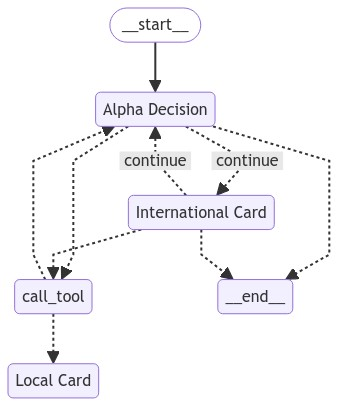

In [185]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [207]:
topic = table_fee_have_acc_follow_number_transaction

In [215]:
topic = """STT	Hình Thức Thanh Toán	Phí Dịch Vụ (% của Tổng Giá Trị Giao Dịch Thành công)\
1	Thẻ Quốc Tế (phát hành tại Việt Nam)	1.8%\
2	Thẻ Quốc Tế (phát hành ngoài Việt Nam)	2.5%\
"""

In [257]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma seperate list what schema need to config about the contract , if any config relate let pick a list, list value we have here(remember we don't pick all just pick what config relate [QR_Config, International_card_config, local_card_config, QR_Acc_config] , QR_Acc_config be used when QR have condition more about amount or number of transactions, if don't have any condition not using accumulate config : {topic}""" #"""Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate schema of {subject} Here is template for International Card schema config only, so let mapping International Card fee relate to the schema fee config follow format. The no number of schema(no_of_schema) will be information from the table below.
schemeName	layer	attribute	operator	value
Thẻ quốc tế VISA, MASTER, JCB phát hành trong VN	condition_trans_selector	buyer_sf_acct_subtype	=	INTERNATIONAL_CARD
	condition_trans_selector	og_trans_type	'in_or ='	base on context user provide, default is 'Purchase' if not mention,value available'''Purchase, Refund'''
	condition_trans_selector	buyer_sf_issuer_country	=	Base on schema context '''INSIDE_VN, OUTSIDE_VN'''
	condition_trans_selector	buyer_sf_acct_type	=	CARD
	condition_trans_selector	buyer_sf_acct_issuer	in	Base on context, value available:'''VISA,MASTER,JCB,AMEX,...'''
	condition_entity_selector	merc_id	=	
	condition_trans_selector	og_status	=	1
	condition_trans_selector	og_platform	'in_or ='	Ask user, value available '''PAYMENT_GATEWAY,SMARTPOS,OTHERS'''
	fee_setup	x1	=	om_order_amount
	fee_setup	pct_fee	=	'''int number'''
	fee_setup	fix_fee	Base on schema context '''INSIDE_VN, OUTSIDE_VN'''	'''int number'''
	fee_setup	max_fee	=	'''int number'''
	fee_setup	min_fee	=	'''int number'''
	effective_date	start_date	=	Ask  user to fill this Fields and format follow e.g: 01/01/2024
	effective_date	end_date	=	Ask  user to fill this Fields and format follow e.g: 12/31/2024
	additional_condition	function	=	MDR-FeePerTrans
	pay_fee_ratio	pay_merchant_amount	=	1
	recv_fee_ratio	recv_sp_amount	=	1"""# """Generate a joke about '''subject'''"""
best_joke_prompt = """add a bunch of schem in a list and Return for me
{schemas}"""


class Subjects(BaseModel):
    subjects: list[str]


class SchemaConfig(BaseModel):
    schema_config: str


class ListSchema(BaseModel):
    list_schema: list


model = claude35_sonnet

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    schemas: Annotated[list, operator.add]
    list_schema: list


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class SchemaState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_schema_list(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_schema(state: SchemaState):
    # prompt = joke_prompt.format(subject=state["subject"])
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(SchemaConfig).invoke(prompt)
    return {"schemas": [response.schema_config]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_schemas(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_schema", {"subject": s}) for s in state["subjects"]]

    
# Here we will judge the best joke
def best_joke(state: OverallState):
    schemas = "\n\n".join(state["schemas"])
    prompt = best_joke_prompt.format(topic=state["topic"], schemas=schemas)
    response = model.with_structured_output(ListSchema).invoke(prompt)
    return {"list_schema": state["schemas"][response.list_schema]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_schema_list", generate_schema_list)
graph.add_node("generate_schema", generate_schema)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_schema_list")
graph.add_conditional_edges("generate_schema_list", continue_to_schemas, ["generate_schema"])
graph.add_edge("generate_schema", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

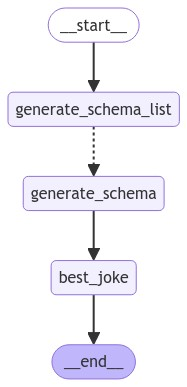

In [258]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [259]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": topic}):
    print(s)

{'generate_schema_list': {'subjects': ['International_card_config']}}
{'generate_schema': {'schemas': ['{\n  "schema_name": "International_card_config",\n  "fee_type": "MDR",\n  "no_of_schema": 1,\n  "schema_list": [\n    {\n      "schema_name": "Thẻ quốc tế VISA, MASTER, JCB phát hành trong VN",\n      "condition_trans_selector": [\n        {\n          "buyer_sf_acct_subtype": "INTERNATIONAL_CARD"\n        },\n        {\n          "og_trans_type": {\n            "in_or =": ["Purchase"]\n          }\n        },\n        {\n          "buyer_sf_issuer_country": "INSIDE_VN"\n        },\n        {\n          "buyer_sf_acct_type": "CARD"\n        },\n        {\n          "buyer_sf_acct_issuer": {\n            "in": ["VISA", "MASTER", "JCB"]\n          }\n        },\n        {\n          "og_status": 1\n        },\n        {\n          "og_platform": {\n            "in_or =": ["<UNKNOWN>"]\n          }\n        }\n      ],\n      "condition_entity_selector": [\n        {\n          "merc_id

TypeError: list indices must be integers or slices, not list

In [1]:
import json

file_path = '/Users/leduy/PycharmProjects/Funny_days_wRAG/dataset/fec_ibft.fec_ibft.json'

with open(file_path, 'r') as file:
    for line in file:
        try:
            data = json.loads(line)
            # Process each JSON object here
            # For example, print or store only what's necessary
            print(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{'_id': {'$oid': '636780ca6ae2454d9423850c'}, 'partnerCode': 'FEC247', 'partnerTransId': '3229402', 'partnerTransTime': '06/11/2022 09:39:21', 'accType': 1, 'accNo': '0858821123', 'bankCode': '970403', 'amt': '20000000', 'partnerDesc': 'FE Credit giai ngan cho so App 81609557 hop dong 202211061908455 voi so tien 20000000 VND', 'created': 1667727562732, 'partnerExtraData': '', 'partnerAppId': '81609557', 'benfName': 'PHAN VAN HAI', 'cnFee': 'B2C', 'cnStat': 'OK', 'cnTransId': 'SMP221106000146', 'cnTransTime': '1667727562755', 'modified': 1667727563888, 'bRespCode': '1', 'bTId': '231009824002', 'bTransTime': '1106', 'errDesc': None, 'status': 0}
{'_id': {'$oid': '6367812617138e3be552cecc'}, 'partnerCode': 'FEC247', 'partnerTransId': '3229405', 'partnerTransTime': '06/11/2022 09:40:53', 'accType': 1, 'accNo': '0801000289960', 'bankCode': '970436', 'amt': '10000000', 'partnerDesc': 'FE Credit giai ngan cho so App 81603786 hop dong 202211069908464 voi so tien 10000000 VND', 'created': 16677

In [ ]:

# Initialize a list to store parsed JSON objects
json_objects = []

# Open the file and read it line by line
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line as a JSON object and append it to the list
        json_objects.append(json.loads(line.strip()))

# Now json_objects contains all the parsed JSON objects
for obj in json_objects:
    print(obj)